In [1]:
import string
import os
import random
from typing import List, Dict, Tuple
from pathlib import Path

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets
from torchmetrics.functional import char_error_rate
from torchinfo import summary

from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib notebook

Зафиксируем сиды.

**NOTE**: это, к сожалению, не приведёт к воспроизводимости кода - `CTCLoss` в `Pytorch` не умеет работать детерминированно ([ссылка](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html)). Отметим, однако, что в [документации](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html#torch.nn.CTCLoss) к `CTCLoss` написано, что изменение `torch.backends.cudnn.deterministic=True` приведёт к выбору детерминированного алгоритма, что некорректно - согласно [этой](https://stackoverflow.com/questions/66130547/what-does-the-difference-between-torch-backends-cudnn-deterministic-true-and) ссылке данный параметр влияет только на детерминированность вычисления свёрток.

Невозможность выбора детерминированного алгоритма несколько странна, поскольку такой алгоритм поддерживается `cuDNN` - [вот](https://docs.nvidia.com/deeplearning/cudnn/api/index.html#cudnnCTCLossAlgo_t). Проверим наличие `cuDNN`...

In [2]:
torch.backends.cudnn.enabled

True

Как-то так.

In [110]:
seed = 42069

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Будем имплементировать `CRNN` согласно [этой](https://arxiv.org/pdf/1507.05717.pdf) статье.
В качестве лосса пока будем использовать предложенный там `CTCLoss`.

Отметим, что в статье есть небольшие ошибки - для картинки размером `100x32` в рекуррентный слой будет подаваться последовательность не длины 25, а длины 24. Также отметим, что каждый элемент последовательности содержит информацию не о прямоугольной области, а немного искривлённой из-за `MaxPooling`-слоёв, которые просто так убирать не стоит - если так сделать, то соседние элементы последовательности будут отличаться всего на 2 (крайних) столбца, и мы будем таскать с собой много повторяющейся информации. 

Ещё один интересный момент, связанный с `MaxPooling`-слоями - размер `stride`. Изначально мы допустили ошибку, поставив `stride=2`, но сеть всё ещё обучалась, при том даже немного быстрее. Этот вариант, тем не менее, был отвергнут, поскольку результирующая последовательность для картинки шириной `100` будет длиной всего `6`, а это вызовет проблемы при декодировании, которые опишем далее.

Отметим, что для предсказания повторяющихся подряд идущих символов нужна бОльшая длина последовательности. Так, для капчи `cd5ff` одним из вариантов правильного предсказания будет `cd5f-f`, а `cd5ff` будет неправильно, поскольку последовательные повторения убираются (т.о., получится `cd5f`). Худшим случаем, очевидно, будет последовательность из одинаковых символов, например, `fffff`, для которой минимальная описывающая последовательность имеет вид `f-f-f-f-f`, которая имеет длину 9.

К сожалению, мы, скорее всего, допустили какие-то ошибки при реализации модели согласно статье - заявленное число параметров (8.3м) не соответствует тому, что получили мы (8.7м). Однако, мы всё же убеждены в том, что имплементированное решение достаточно неплохо подходит для решения поставленной задачи, в чём мы также убедимся чуть далее.

**Note**: Датасет в каждом рассматривамом случае разделён близко к отношению `4x1` так, чтобы получались целые батчи.

In [111]:
class OCRDataset(torch.utils.data.Dataset):
    CHARS = string.digits + string.ascii_lowercase
    CHAR_TO_LABEL = {char: label for label, char in enumerate(CHARS, start=1)}
    LABEL_TO_CHAR = {label: char for char, label in CHAR_TO_LABEL.items()}
    
    def __init__(self, root_dir: str = 'root/samples', desired_width: int = 80, desired_height: int = 32):
        super().__init__()
        self.root_dir = root_dir
        self.path = Path(root_dir)
        self.width = desired_width
        self.height = desired_height
        self.filepaths = [x.name for x in self.path.glob('*')]
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx: int):
        path = f"{self.root_dir}/{self.filepaths[idx]}"
        
        image = Image.open(path)
        image = image.resize((self.width, self.height)).convert('L')
        image = torch.from_numpy(np.array(image).astype(np.float32)).unsqueeze(0)
        
        target = [self.CHAR_TO_LABEL[x] for x in self.filepaths[idx].split('.')[0]]
        target = torch.LongTensor(target)
        
        return image, target

In [112]:
class CRNN(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 37):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 512
        self.height = 32
        self.rnn_hidden_size = 256
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=512, out_channels=self.out_channels, kernel_size=2, stride=1, padding=0),
        )
                
        self.rec_layers = nn.LSTM(self.out_channels, self.rnn_hidden_size, bidirectional=True, num_layers=2)
        
        self.clf_layer = nn.Linear(2 * self.rnn_hidden_size, self.num_classes)
        
    def forward(self, x: torch.Tensor):
        x = self.conv_layers(x)  # Outputs (Bsize, Cnum, H, W)
        
        batch_size, ch_num, height, width = x.size()
                
        # We need to concat all channels columnwise
        x = x.view(batch_size, ch_num * height, width)
        x = x.permute(2, 0, 1)

        x, _ = self.rec_layers(x)
        x = self.clf_layer(x)
        return x  # Output is of shape (width, bsize, num_classes)

In [113]:
class ModifiedCRNN(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 37):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 256
        self.height = 32
        self.rnn_hidden_size = 256
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(  # (32, 176)
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> (16, 88)
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # -> (8, 44)
            nn.ReLU(),
            
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),  # -> (4, 22)
            nn.ReLU(),
            
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),  # -> (2, 11)
            nn.ReLU(),
            
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=self.out_channels, kernel_size=2, stride=1, padding=0),  # -> (1, 10)
        )
        
        self.rec_layers = nn.LSTM(self.out_channels, self.rnn_hidden_size, bidirectional=True, num_layers=2)
        
        self.clf_layer = nn.Linear(2 * self.rnn_hidden_size, self.num_classes)
        
    def forward(self, x: torch.Tensor):
        x = self.conv_layers(x)  # Outputs (Bsize, Cnum, H, W)
        
        batch_size, ch_num, height, width = x.size()
                
        
        # We need to concat all channels columnwise
        x = x.view(batch_size, ch_num * height, width)
        x = x.permute(2, 0, 1)

        x, _ = self.rec_layers(x)
        x = self.clf_layer(x)
        return x  # Output is of shape (width, bsize, num_classes)

In [114]:
class CECRNN(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 37):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 512
        self.height = 32
        self.hidden_seq_size = 128
        self.rnn_hidden_size = 256
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(  # (32, 128)
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> (16, 64)
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> (8, 32)
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),  # -> (4, 16)
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 5), stride=1, padding=1),  # -> (4, 14)
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 5), stride=1, padding=1),  # -> (4, 12)
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2),  # -> (2, 6)
            nn.Conv2d(in_channels=512, out_channels=self.out_channels, kernel_size=2, stride=1, padding=0),  # -> (1, 5)
        )
                
        self.rec_layers = nn.LSTM(self.out_channels, self.rnn_hidden_size, bidirectional=True, num_layers=2, dropout=0.2)
        
        self.clf_layer = nn.Linear(2 * self.rnn_hidden_size, self.num_classes)
        
    def forward(self, x):
        x = self.conv_layers(x)  # Outputs (Bsize, Cnum, H, W)
        
        batch_size, ch_num, height, width = x.size()
        
        assert ch_num == self.out_channels
        
        # We need to concat all channels columnwise
        
        x = x.view(batch_size, ch_num * height, width)
        x = x.permute(2, 0, 1)
        
        x, _ = self.rec_layers(x)
        x = self.clf_layer(x)
        return x  # Output is of shape (width, bsize, num_classes)

In [115]:
def get_grad_norm(model: nn.Module) -> List[float]:  # For local tests
    total_norm = 0
    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
    for p in parameters:
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [116]:
def train_model_ctc(model: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    scheduler: torch.optim.lr_scheduler._LRScheduler,
                    criterion: nn.modules.loss._Loss,
                    train_loader: torch.utils.data.DataLoader,
                    test_loader: torch.utils.data.DataLoader,
                    num_epochs: int = 100) -> Dict[str, List[str]]:
    losses = {'train': [], 'test': []}
    
    with torch.no_grad():
        test_images, test_targets = [elem.to(device) for elem in next(iter(test_loader))]
        true_subsample = [[dataset.LABEL_TO_CHAR[elem.item()] for elem in target] for target in test_targets[:10]]
        test_target_lengths = torch.LongTensor([5 for _ in range(len(test_images))])


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    plt.ion()

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for train_data in train_loader:

            images, targets = [elem.to(device) for elem in train_data]

            logits = model(images)

            # recall that dims are (width, bsize, num_classes)
            log_probas = f.log_softmax(logits, dim=2)

            input_lengths = torch.LongTensor([logits.size(0)] * logits.size(1))
            target_lengths = torch.LongTensor([5 for _ in range(len(images))])

            loss = criterion(log_probas, targets, input_lengths, target_lengths)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()
            losses['train'].append(loss.item())

        model.eval()
        with torch.no_grad():

            logits = model(test_images)

            # recall that dims are (width, bsize, num_classes)
            log_probas = f.log_softmax(logits, dim=2)

            input_lengths = torch.LongTensor([logits.size(0)] * logits.size(1))
            loss = criterion(log_probas, test_targets, input_lengths, test_target_lengths)

    #         pred = [[dataset.LABEL_TO_CHAR.get(s.item(), '-') for s in ss] for ss in torch.argmax(log_probas.permute((1, 0, 2))[:10], axis=2)]
    #         print(*zip(pred, true_subsample), sep='\n')

            losses['test'].append(loss.item())

        if scheduler is not None:
            scheduler.step()

        for ax, title in zip(axes, ['train', 'test']):
            ax.cla()
            ax.set_title(f'{title} CTC')
            ax.plot(losses[title], label=f"last_loss: {losses[title][-1]:.5f}")
            ax.legend()

        fig.canvas.draw()
        
    return losses

In [117]:
def train_model_ce(model: nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scheduler: torch.optim.lr_scheduler._LRScheduler,
                   criterion: nn.modules.loss._Loss,
                   train_loader: torch.utils.data.DataLoader,
                   test_loader: torch.utils.data.DataLoader,
                   num_epochs: int = 100) -> Dict[str, List[float]]:
    losses = {'train': [], 'test': []}

    with torch.no_grad():
        test_images, test_targets = [elem.to(device) for elem in next(iter(test_loader))]
        true_subsample = [[dataset.LABEL_TO_CHAR[elem.item()] for elem in target] for target in test_targets[:10]]


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    plt.ion()

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        for train_data in train_loader:

            images, targets = [elem.to(device) for elem in train_data]

            # recall that dims are (width, bsize, num_classes)
            logits = model(images).permute((1, 2, 0))
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            losses['train'].append(loss.item())

        model.eval()
        with torch.no_grad():
            logits = model(test_images).permute((1, 2, 0))
            loss = criterion(logits, test_targets)
            losses['test'].append(loss.item())

        if scheduler is not None:
            scheduler.step()

        for ax, title in zip(axes, ['train', 'test']):
            ax.cla()
            ax.set_title(f'{title} CE')
            ax.plot(losses[title], label=f"last_loss: {losses[title][-1]:.5f}")
            ax.legend()

        fig.canvas.draw()
        
    return losses

In [118]:
def get_distinct_words(predictions: List[str], ground_truth: List[str]) -> List[Tuple[str, str]]:
    return [(pred, true) for pred, true in zip(predictions, ground_truth) if pred != true]

def draw_distincts(predictions: List[str], ground_truth: List[str], path: str) -> None:
    distincts = get_distinct_words(predictions, ground_truth)
    
    fig = plt.figure(figsize=(10, 8))
    
    rows = 10
    cols = 5
    
    folder_path = Path(path)
    
    for i, (pred, true) in enumerate(distincts, start=1):
        file = next(folder_path.glob(f'{true}.*'))
        img = Image.open(file)
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(img)
        ax.axis('off')
        ax.text(0, 10, f"{pred}/{true}", color='green')
        ax.text(0, 60, f"cer={char_error_rate(pred, true):.2f}", color='red')
    
    plt.show()

## CRNN

In [15]:
summary(CRNN(in_channels=1, num_classes=37), (8, 1, 32, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [24, 8, 37]               --
├─Sequential: 1-1                        [8, 512, 1, 24]           --
│    └─Conv2d: 2-1                       [8, 64, 32, 100]          640
│    └─MaxPool2d: 2-2                    [8, 64, 16, 50]           --
│    └─ReLU: 2-3                         [8, 64, 16, 50]           --
│    └─Conv2d: 2-4                       [8, 128, 16, 50]          73,856
│    └─MaxPool2d: 2-5                    [8, 128, 8, 25]           --
│    └─ReLU: 2-6                         [8, 128, 8, 25]           --
│    └─Conv2d: 2-7                       [8, 256, 8, 25]           295,168
│    └─ReLU: 2-8                         [8, 256, 8, 25]           --
│    └─Conv2d: 2-9                       [8, 256, 8, 25]           590,080
│    └─MaxPool2d: 2-10                   [8, 256, 4, 25]           --
│    └─ReLU: 2-11                        [8, 256, 4, 25]           --


In [156]:
dataset = OCRDataset(desired_width=100)

batch_size = 8

train_set, test_set = torch.utils.data.random_split(OCRDataset(), [820, 250], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [93]:
crnn = CRNN(in_channels=1, num_classes=len(dataset.CHAR_TO_LABEL) + 1)
crnn.to(device)

optimizer = torch.optim.Adadelta(crnn.parameters(), lr=0.08)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
criterion = nn.CTCLoss(zero_infinity=True)
criterion.to(device)

CTCLoss()

Будем обучать сеть в 2 этапа - сначала 20 эпох, а потом ещё 40. Это нужно, поскольку через 20 эпох величина изменения лосса будет очень маленькой в сравнении с тем, что было в начале (и заметить эти изменения визуально станет сложно).

<IPython.core.display.Javascript object>


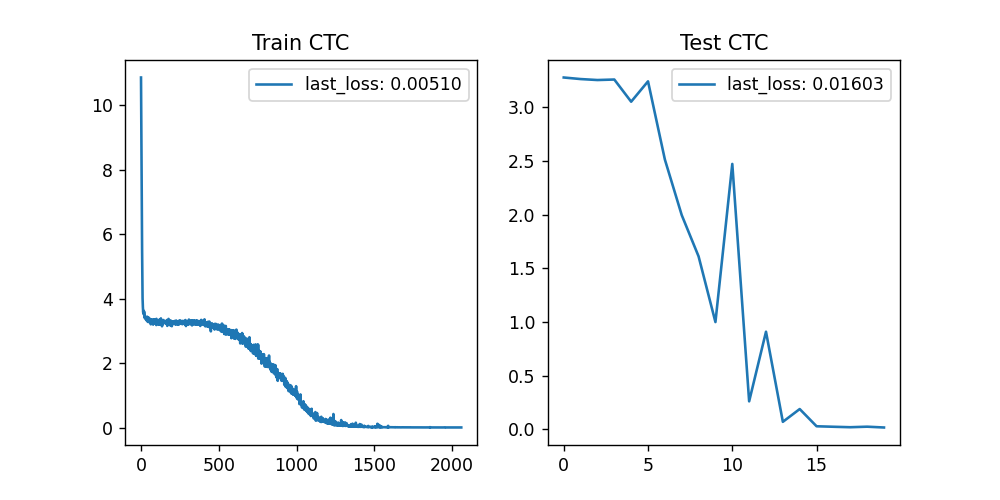

100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


In [94]:
losses = train_model_ctc(
    model=crnn,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=20
)

<IPython.core.display.Javascript object>


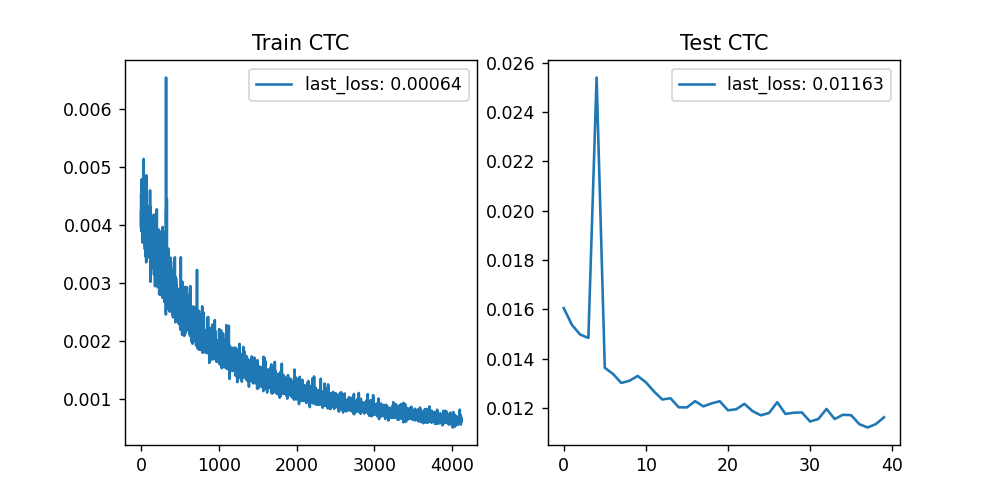

100%|██████████| 40/40 [02:34<00:00,  3.86s/it]


In [95]:
losses = train_model_ctc(
    model=crnn,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=40
)

In [96]:
crnn.eval()

predictions = []
ground_truth = []
with torch.no_grad():
    for data in test_loader:
        images, targets = [elem.to(device) for elem in data]

        logits = crnn(images)

        # recall that dims are (width, bsize, num_classes)
        log_probas = f.log_softmax(logits, dim=2)

        input_lengths = torch.LongTensor([logits.size(0)] * logits.size(1))
        target_lengths = torch.LongTensor([5 for _ in range(len(images))])

        loss = criterion(log_probas, targets, input_lengths, target_lengths)

        # decoding net's results
        for pred_probas, true_res in zip(log_probas.permute((1, 0, 2)), targets):
            pred = torch.argmax(pred_probas, axis=1)
            pred = torch.unique_consecutive(pred)
            char_pred = [dataset.LABEL_TO_CHAR.get(elem.item(), '') for elem in pred]

            res_str = ''.join(char_pred)

            target_decoded = [dataset.LABEL_TO_CHAR[elem.item()] for elem in true_res]
            target_decoded = ''.join(target_decoded)
            
            predictions.append(res_str)
            ground_truth.append(target_decoded)

In [97]:
char_error_rate(predictions, ground_truth)

tensor(0.0024)

<IPython.core.display.Javascript object>


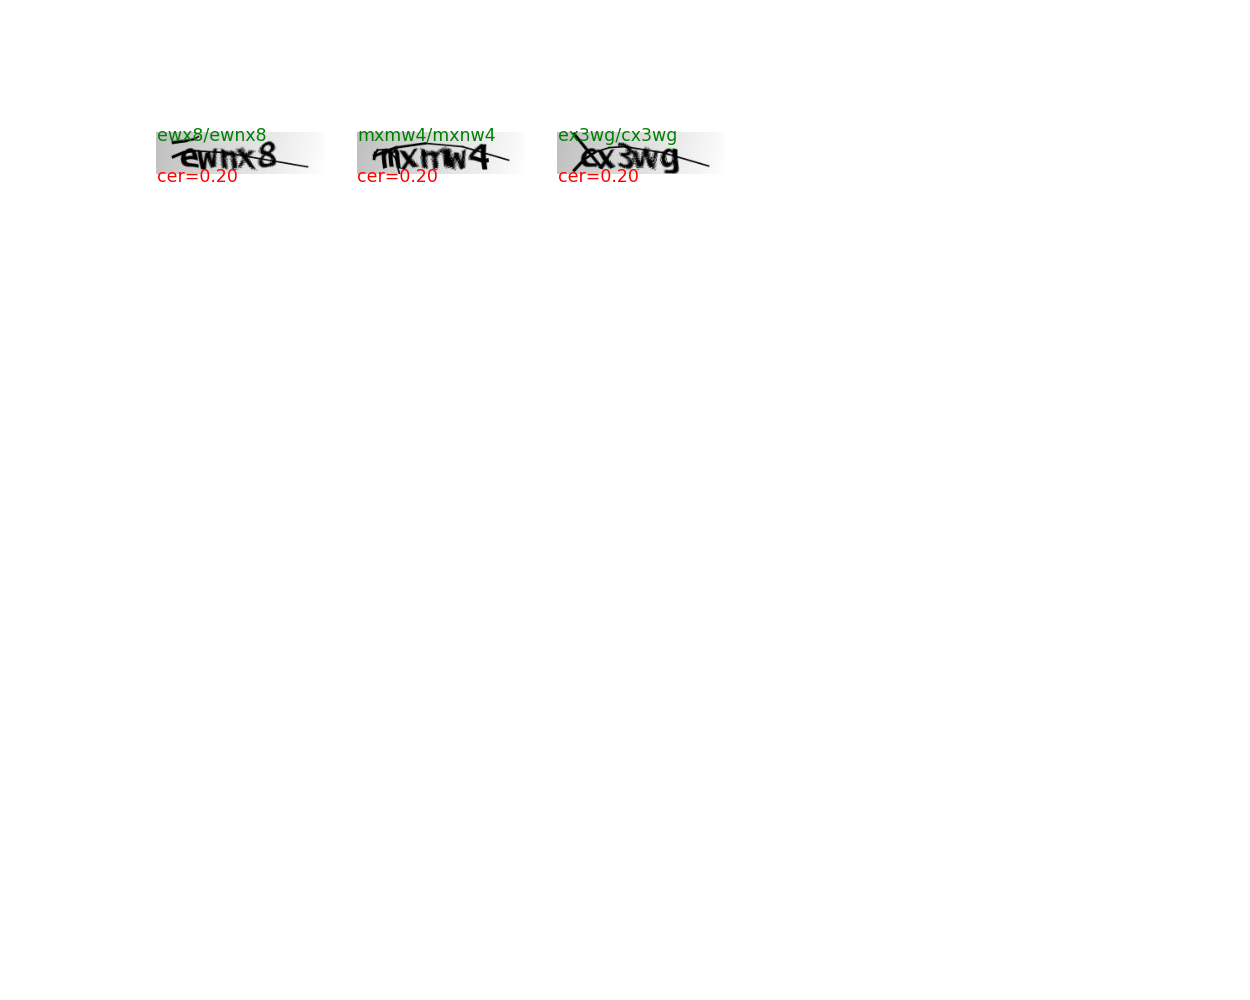

In [98]:
draw_distincts(predictions, ground_truth, dataset.root_dir)

Отличный результат! Однако, стоит отметить, что мы могли бы добиться желаемых результатов (`CER < 10%`) и с меньшим числом параметров, изменив несколько моментов:

1) Для данной задачи `CNN` слой кажется немного переосложнённым (напомним, желаемые последовательности после обработки должны иметь длину всего 5), можно уменьшить размерности выходных каналов

2) В данной архитектуре на выходе `CNN` слоя получается последовательность длины 25, что разумно для задачи `Text recognition` в целом, но нам хватит и меньшей длины. Для нашей задачи последовательности должны быть хотя бы длины `9`. Преобразуем `CNN` слой ещё и так, чтобы на выходе были последовательности длины `10`

3) Избавимся от `MaxPool`-слоёв в конце. Как было отмечено выше, каждый `MaxPooling`-слой приводит к тому, что каждый столбец последовательности содержит в себе уже не прямоугольную область, а немного искривлённую. Добавление `MaxPool`-слоёв в конце `CNN`-части может привести к смешиванию представления букв в последовательности. Вместо них увеличим размер `stride` в `Conv`-слоях - такие действия, в отличие от `MaxPooling`-а, не искривляют область ещё больше, поэтому их наличие в конце оправдано.


Ещё заметим, что во втором примере явная ошибка - сеть (насколько мы можем судить) правильно классифицировала капчу, но разметка утверждает обратное. Отметим, что это не первый такой случай ([ссылка](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images/discussion/81891), но этот лейбл поправлен), так что...да...

Теперь перейдём к модифицированной сети.

## Modified CRNN

In [120]:
summary(ModifiedCRNN(in_channels=1, num_classes=37), input_size=(128, 1, 32, 176))

Layer (type:depth-idx)                   Output Shape              Param #
ModifiedCRNN                             [10, 128, 37]             --
├─Sequential: 1-1                        [128, 256, 1, 10]         --
│    └─Conv2d: 2-1                       [128, 64, 32, 176]        640
│    └─MaxPool2d: 2-2                    [128, 64, 16, 88]         --
│    └─ReLU: 2-3                         [128, 64, 16, 88]         --
│    └─Conv2d: 2-4                       [128, 128, 8, 44]         73,856
│    └─ReLU: 2-5                         [128, 128, 8, 44]         --
│    └─BatchNorm2d: 2-6                  [128, 128, 8, 44]         256
│    └─Conv2d: 2-7                       [128, 256, 4, 22]         295,168
│    └─ReLU: 2-8                         [128, 256, 4, 22]         --
│    └─BatchNorm2d: 2-9                  [128, 256, 4, 22]         512
│    └─Conv2d: 2-10                      [128, 256, 2, 11]         590,080
│    └─ReLU: 2-11                        [128, 256, 2, 11]         -

In [116]:
dataset = OCRDataset(desired_width=176)

batch_size = 128

train_set, test_set = torch.utils.data.random_split(dataset, [896, 174], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [122]:
crnn = ModifiedCRNN(in_channels=1, num_classes=len(dataset.CHAR_TO_LABEL) + 1)
crnn.to(device)

optimizer = torch.optim.Adadelta(crnn.parameters(), lr=1.2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CTCLoss(zero_infinity=True)
criterion.to(device)

num_epochs = 40

<IPython.core.display.Javascript object>


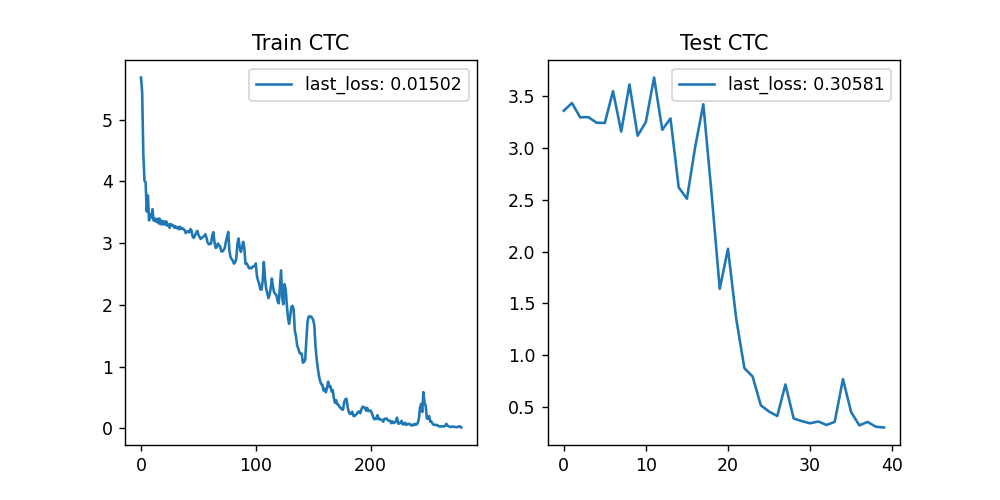

100%|██████████| 40/40 [01:52<00:00,  2.81s/it]


In [123]:
losses = train_model_ctc(
    model=crnn,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=num_epochs
)

In [124]:
crnn.eval()

predictions = []
ground_truth = []
with torch.no_grad():
    for data in test_loader:
        images, targets = [elem.to(device) for elem in data]

        logits = crnn(images)

        # recall that dims are (width, bsize, num_classes)
        log_probas = f.log_softmax(logits, dim=2)

        input_lengths = torch.LongTensor([logits.size(0)] * logits.size(1))
        target_lengths = torch.LongTensor([5 for _ in range(len(images))])

        loss = criterion(log_probas, targets, input_lengths, target_lengths)

        # decoding net's results
        for pred_probas, true_res in zip(log_probas.permute((1, 0, 2)), targets):
            pred = torch.argmax(pred_probas, axis=1)
            pred = torch.unique_consecutive(pred)
            char_pred = [dataset.LABEL_TO_CHAR.get(elem.item(), '') for elem in pred]

            res_str = ''.join(char_pred)

            target_decoded = [dataset.LABEL_TO_CHAR[elem.item()] for elem in true_res]
            target_decoded = ''.join(target_decoded)
            
            predictions.append(res_str)
            ground_truth.append(target_decoded)

In [125]:
char_error_rate(predictions, ground_truth)

tensor(0.0575)

<IPython.core.display.Javascript object>


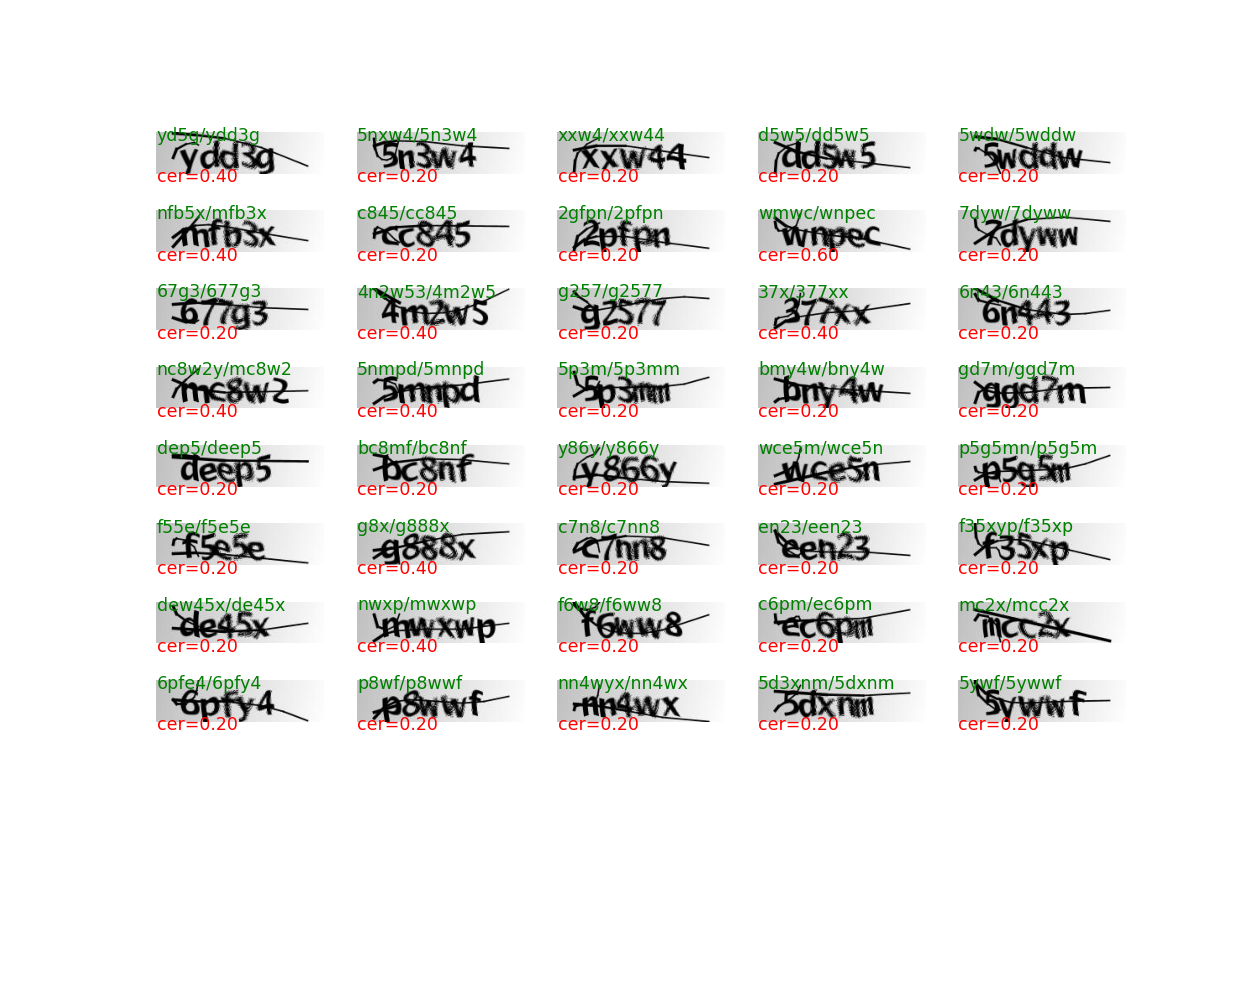

In [127]:
draw_distincts(predictions, ground_truth, dataset.root_dir)

Таки вот, `CER` составляет `~5.8%`. Стоит отметить, однако, что она совершает довольно много ошибок. Связаны они в основном с повторениями, но почему так происходит мы, к сожалению, полностью не можем объяснить. Частично это однозначно связано с самим датасетом - вариативности слишком мало ([ссылка](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images/discussion/82470)). Это проявляется в ошибках сети - большинство из них связано либо с повторениями (что, возможно, говорит о том, что стоит увеличить размер последовательности, например, до 15, чтобы дать сети больший простор для выдачи), либо с ошибками с буквой `n` (которая встречается чаще всего). Хорошим решением может быть аугментация данных, чтобы немного "выровнять" распределение. Проверим ещё на всякий случай количество капчей с повторяющимися символами.

In [81]:
def get_num_repeatitions(cur_set):
    num_repeatitions = 0
    for index in cur_set.indices:
        _, captcha_labeled = dataset[index]
        for i in range(len(captcha_labeled) - 1):
            if captcha_labeled[i] == captcha_labeled[i + 1]:
                num_repeatitions += 1
                break
    
    return num_repeatitions
                
num_repeatitions_train = get_num_repeatitions(train_set)
num_repeatitions_test = get_num_repeatitions(test_set)
print(f"train: {num_repeatitions_train}/{len(train_set)}")
print(f"test: {num_repeatitions_test}/{len(test_set)}")

train: 177/864
test: 44/206


Выглядит не так уж и плохо!

## CRNN for CELoss

Напоследок, давайте вставим вместо `CTCLoss` стандартную кросс-энтропию. За основу возьмём первую версию `CRNN`, и перепишем архитектуру сети так, чтобы на слой `RNN` подавались последовательности длины 5 - тогда можно забыть про `-`. Изменим также размеры входа - преобразуем картинки из исходного размера (`200x50`) в `128x32`, так мы сохраним соотношение (`4x1`), и немного сожмём изображение.

In [119]:
summary(CECRNN(in_channels=1, num_classes=37), (16, 1, 32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CECRNN                                   [5, 16, 37]               --
├─Sequential: 1-1                        [16, 512, 1, 5]           --
│    └─Conv2d: 2-1                       [16, 64, 32, 128]         640
│    └─MaxPool2d: 2-2                    [16, 64, 16, 64]          --
│    └─ReLU: 2-3                         [16, 64, 16, 64]          --
│    └─Conv2d: 2-4                       [16, 128, 16, 64]         73,856
│    └─MaxPool2d: 2-5                    [16, 128, 8, 32]          --
│    └─ReLU: 2-6                         [16, 128, 8, 32]          --
│    └─Conv2d: 2-7                       [16, 256, 8, 32]          295,168
│    └─MaxPool2d: 2-8                    [16, 256, 4, 16]          --
│    └─ReLU: 2-9                         [16, 256, 4, 16]          --
│    └─Conv2d: 2-10                      [16, 512, 4, 14]          1,966,592
│    └─ReLU: 2-11                        [16, 512, 4, 14]          -

In [102]:
dataset = OCRDataset(desired_width=128)

batch_size = 16

train_set, test_set = torch.utils.data.random_split(dataset, [848, 222], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

crnn = CECRNN(in_channels=1, num_classes=len(dataset.CHAR_TO_LABEL) + 1)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=4e-5)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

<IPython.core.display.Javascript object>


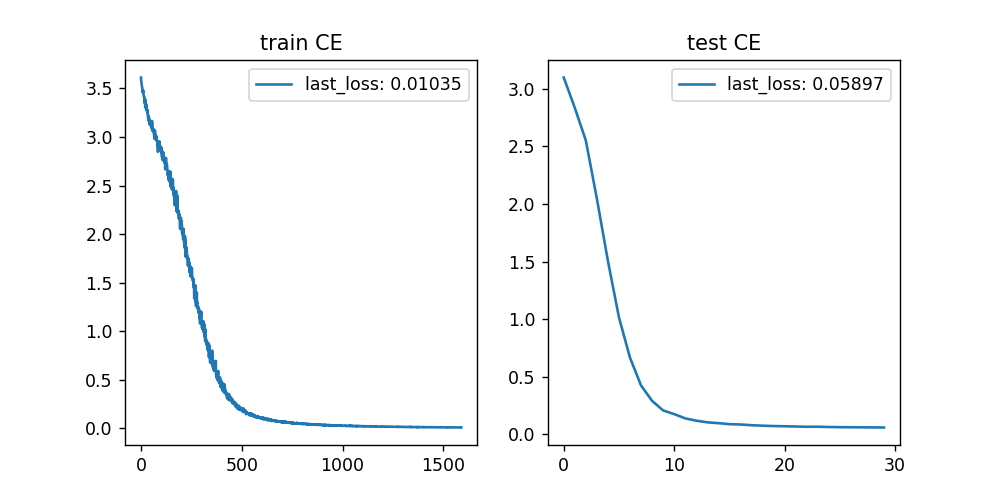

100%|██████████| 30/30 [02:00<00:00,  4.00s/it]


In [104]:

losses = train_model_ce(
    model=crnn,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=30
)

In [105]:
crnn.eval()

predictions = []
ground_truth = []
with torch.no_grad():
    for data in test_loader:
        images, targets = [elem.to(device) for elem in data]

        logits = crnn(images)

        # recall that dims are (width, bsize, num_classes)

        log_probas = f.log_softmax(logits, dim=2)

        # decoding net's results
        for pred_probas, true_res in zip(log_probas.permute((1, 0, 2)), targets):
            pred = torch.argmax(pred_probas, axis=1)
            char_pred = [dataset.LABEL_TO_CHAR.get(elem.item(), '') for elem in pred]

            res_str = ''.join(char_pred)

            target_decoded = [dataset.LABEL_TO_CHAR[elem.item()] for elem in true_res]
            target_decoded = ''.join(target_decoded)
            
            predictions.append(res_str)
            ground_truth.append(target_decoded)

In [106]:
char_error_rate(predictions, ground_truth)

tensor(0.0081)

<IPython.core.display.Javascript object>


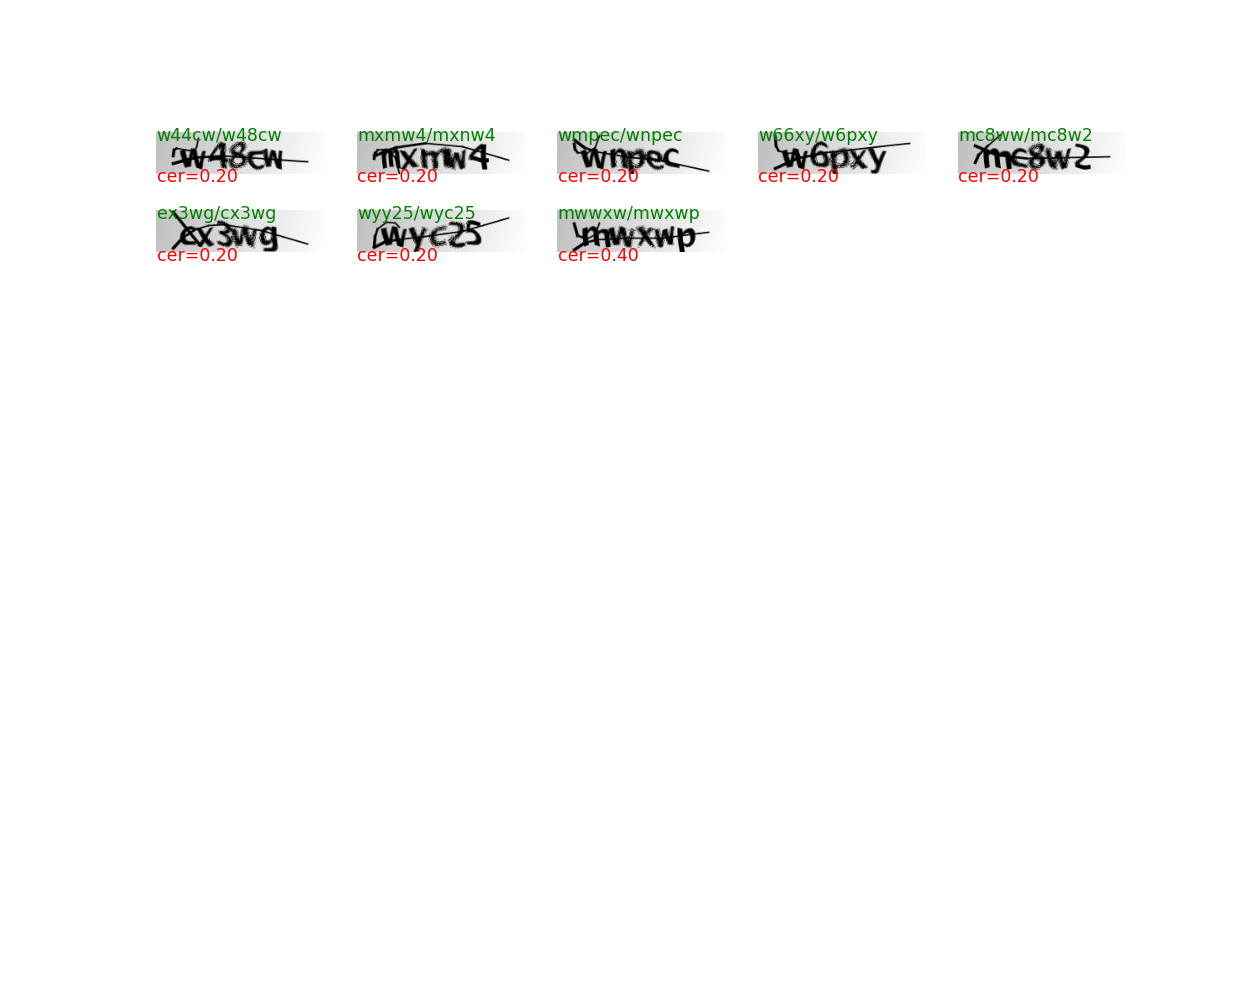

In [107]:
draw_distincts(predictions, ground_truth, dataset.root_dir)

Отлично! Всё работает очень даже достойно. Ошибки сети в целом всё те же - одинаковые символы либо ошибки с буквой `n`.

### Consider running the cell below if you suddenly ran out of GPU memory.

In [117]:
import gc

gc.collect()
torch.cuda.empty_cache()